In [67]:
%pip install boto3 pandas seaborn python-dotenv tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext dotenv
%dotenv

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(16,9)}, palette='husl')

In [5]:
df = pd.read_csv('https://storage.yandexcloud.net/tnn-datasets/youtube_mos.csv', sep=';')
df.head()

,vid,category,resolution,# subjects,MOS full,MOS chunk00,MOS chunk05,MOS chunk10,std full,std chunk00,std chunk05,std chunk10
0,Animation_1080P-01b3,Animation,1080,125,"3,649","3,604","3,721","3,338","0,468","0,574","0,61","0,618"
1,Animation_1080P-05f8,Animation,1080,146,"3,901","3,757","3,671","3,728","0,871","0,734","0,733","0,738"
2,Animation_1080P-0c4f,Animation,1080,127,"3,94","3,831","4,01","4,031","0,529","0,527","0,626","0,692"
3,Animation_1080P-0cdf,Animation,1080,135,"4,245","4,329","4,249","4,249","0,587","0,509","0,494","0,611"
4,Animation_1080P-18f5,Animation,1080,139,"4,158","4,177","3,815","4,02","0,579","0,587","0,612","0,683"


Text(0.5, 0, 'Категория')

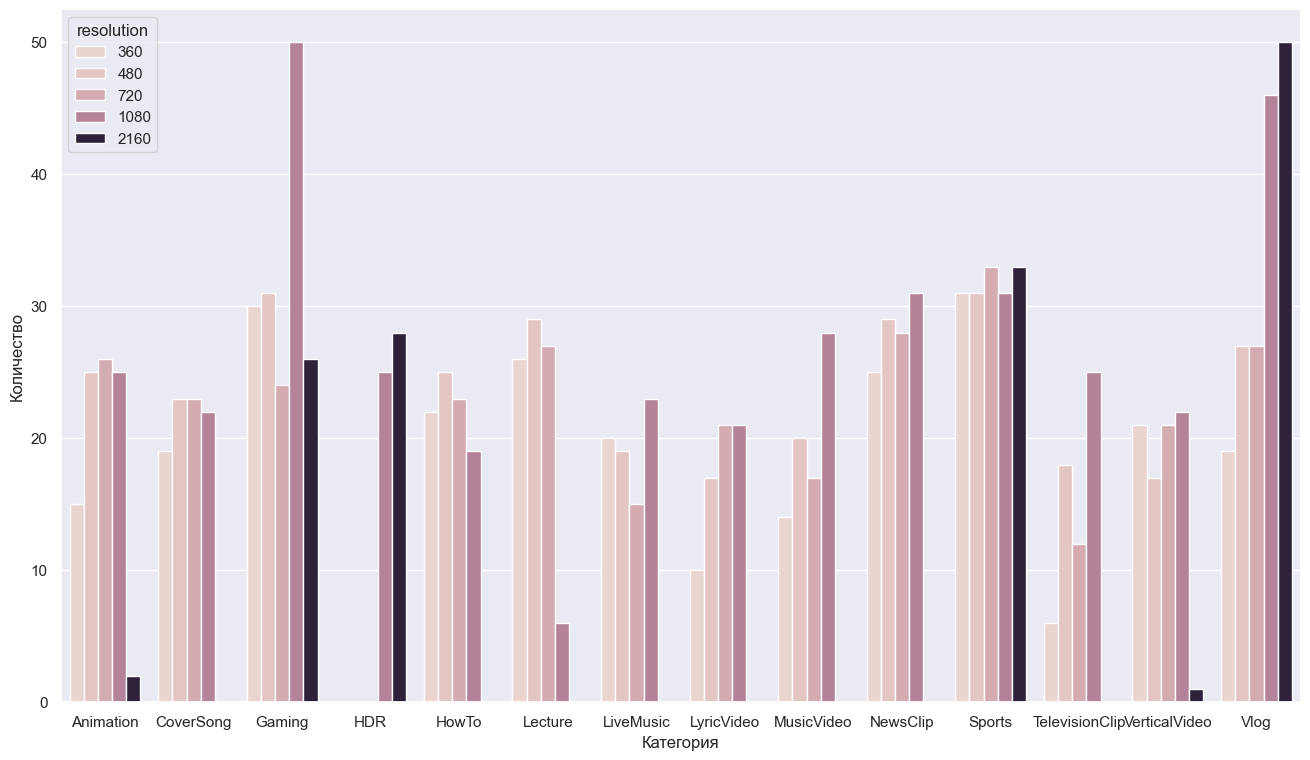

In [35]:
plot = sns.barplot(
    df.groupby(['category', 'resolution']).size().reset_index(),
    x='category',
    y=0,
    hue='resolution',
    # palette='light:purple'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Категория')

/var/folders/4k/2vgv8hbs5sz71c1vn0474t2m0000gn/T/ipykernel_78161/1429781991.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


Text(0.5, 0, 'Разрешение')

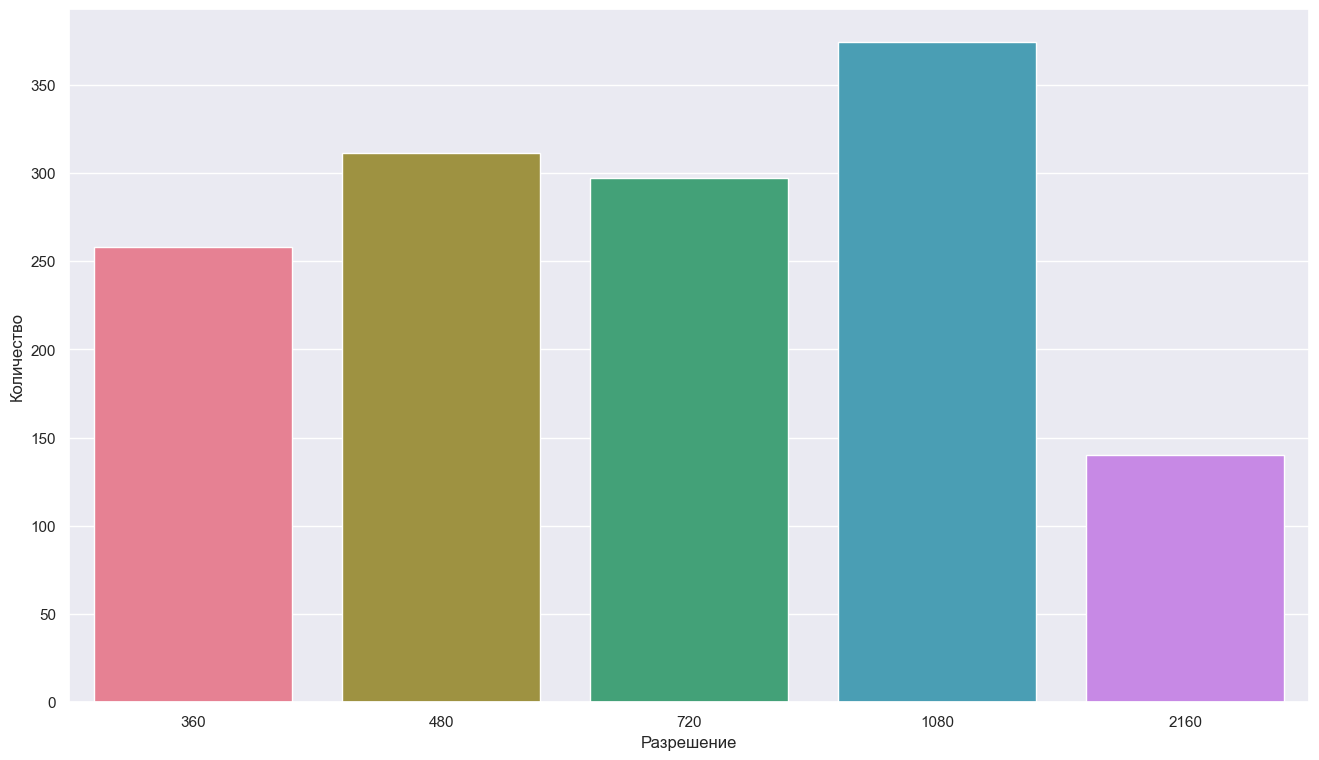

In [39]:
plot = sns.barplot(
    df.groupby(['resolution']).size().reset_index(),
    x='resolution',
    y=0,
    palette='husl'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Разрешение')

/var/folders/4k/2vgv8hbs5sz71c1vn0474t2m0000gn/T/ipykernel_78161/494759709.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


Text(0.5, 0, 'Категория')

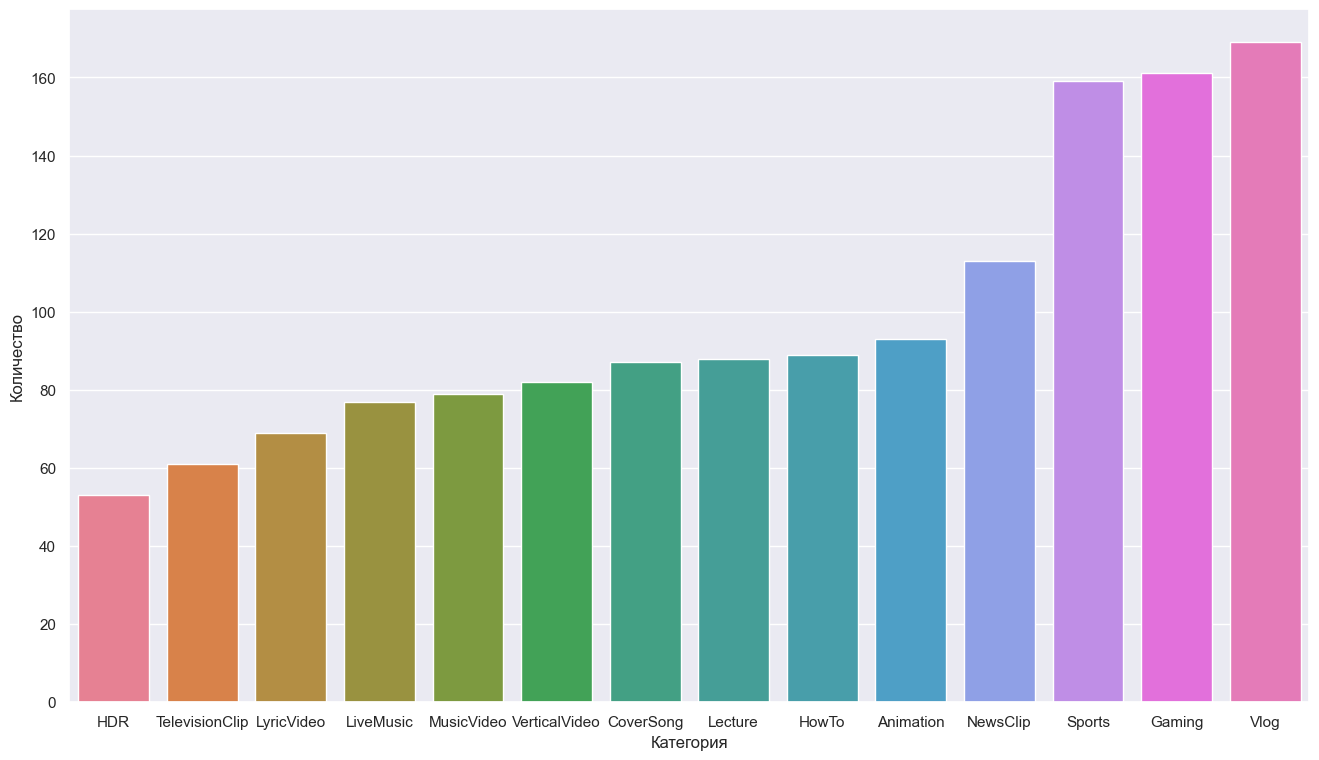

In [43]:
plot = sns.barplot(
    df.groupby(['category']).size().reset_index().sort_values(0),
    x='category',
    y=0,
    palette='husl'
)
plot.set_ylabel('Количество')
plot.set_xlabel('Категория')

In [4]:
import boto3
from botocore.config import Config
import os

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net/',
    aws_access_key_id=os.getenv('S3_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('S3_SECRET_ACCESS_KEY'),
    config=Config(max_pool_connections=100)
)

In [5]:
import logging
from typing import Iterator

def iter_over_bucket(client, bucket) -> Iterator[str]:
    args = {'Bucket': bucket, 'MaxKeys': 500}
    logging.info('list s3 objects')
    res = client.list_objects_v2(**args)
    while res['KeyCount'] > 0:
        logging.info(f'got {res["KeyCount"]} objects')
        for content in res['Contents']:
            yield content['Key']

        token_args = {}
        if next_token := res.get('NextContinuationToken'):
            token_args['ContinuationToken'] = next_token
            res = client.list_objects_v2(**args, **token_args)
        else:
            break

In [68]:
from tqdm import tqdm
features_bucket = 'tnn-feature-datasets'

full_feature_df = []
for path in tqdm(iter_over_bucket(s3_client, features_bucket)):
    csv_data = s3_client.get_object(Bucket=features_bucket, Key=path)['Body']
    feature_df = pd.read_csv(csv_data, sep='|')
    feature_df['path'] = path
    full_feature_df.append(feature_df)

full_feature_df = pd.concat(full_feature_df)
full_feature_df.info()

0it [00:00, ?it/s]

980it [01:59,  8.17it/s]


<class 'pandas.core.frame.DataFrame'>
Index: 583488 entries, 0 to 598
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   width                  583488 non-null  int64  
 1   height                 583488 non-null  int64  
 2   format                 583488 non-null  object 
 3   key_frame              583488 non-null  int64  
 4   time                   583488 non-null  float64
 5   pts                    583488 non-null  int64  
 6   dts                    583488 non-null  int64  
 7   CTI_std                583488 non-null  float64
 8   SI_std                 583488 non-null  float64
 9   TI_std                 582508 non-null  float64
 10  CTI_mean               583488 non-null  float64
 11  SI_mean                583488 non-null  float64
 12  TI_mean                582508 non-null  float64
 13  GLCM_correlation_mean  583488 non-null  float64
 14  GLCM_contrast_mean     583488 non-null  floa

In [70]:
full_feature_df.to_csv('features.csv')

In [71]:
full_feature_df.head()

,width,height,format,key_frame,time,pts,dts,CTI_std,SI_std,TI_std,...,GLCM_homogeneity_mean,GLCM_correlation_std,GLCM_contrast_std,GLCM_energy_std,GLCM_homogeneity_std,FSI13_mean,CI_U_mean,CI_V_mean,FHV13,path
0,1920,1080,yuv420p,1,0.00,0,0,60.721709,42.276787,NaN,...,0.874942,0.001785,13.147321,0.001079,0.021021,74.8750,127.578344,191.367516,18.166667,Animation/1080P/Animation_1080P-05f8.mkv.csv
1,1920,1080,yuv420p,1,0.04,40000,40000,60.752072,43.629593,60.835887,...,0.877909,0.001910,14.082974,0.001086,0.020844,74.6875,127.623374,191.435061,18.114583,Animation/1080P/Animation_1080P-05f8.mkv.csv
2,1920,1080,yuv420p,1,0.08,80000,80000,60.734796,42.469227,60.472099,...,0.879115,0.001818,13.398684,0.001187,0.021489,74.8125,127.663637,191.495455,18.166667,Animation/1080P/Animation_1080P-05f8.mkv.csv
3,1920,1080,yuv420p,1,0.12,120000,120000,60.736063,43.536686,58.674833,...,0.877522,0.001892,13.939902,0.001091,0.021000,74.2500,127.726554,191.589832,17.968750,Animation/1080P/Animation_1080P-05f8.mkv.csv
4,1920,1080,yuv420p,1,0.16,160000,160000,60.722993,42.369629,60.881488,...,0.875207,0.001805,13.295951,0.001074,0.021119,74.7500,127.766877,191.650316,18.135417,Animation/1080P/Animation_1080P-05f8.mkv.csv


In [57]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
qualitys_bucket = 'tnn-video-quality'

def get_df(path: str):
    csv_data = s3_client.get_object(Bucket=qualitys_bucket, Key=path)['Body']
    quality_df = pd.read_csv(csv_data, sep=',')
    quality_df['path'] = path
    return quality_df

full_quality_df = []
all_paths = list(iter_over_bucket(s3_client, qualitys_bucket))
with ThreadPoolExecutor(max_workers=15) as pool:
    for quality_df in tqdm(pool.map(get_df, all_paths), total=len(all_paths)):
        full_quality_df.append(quality_df)

full_quality_df = pd.concat(full_quality_df)
full_quality_df.info()

100%|██████████| 30000/30000 [07:08<00:00, 70.02it/s] 


<class 'pandas.core.frame.DataFrame'>
Index: 18289725 entries, 0 to 598
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Frame                     int64  
 1   integer_motion2           float64
 2   integer_motion            float64
 3   integer_vif_scale0_egl_1  float64
 4   integer_vif_scale1_egl_1  float64
 5   integer_vif_scale2_egl_1  float64
 6   integer_vif_scale3_egl_1  float64
 7   integer_adm2_egl_1        float64
 8   integer_adm_scale0_egl_1  float64
 9   integer_adm_scale1_egl_1  float64
 10  integer_adm_scale2_egl_1  float64
 11  integer_adm_scale3_egl_1  float64
 12  vmaf_neg                  float64
 13  Unnamed: 13               float64
 14  path                      object 
dtypes: float64(13), int64(1), object(1)
memory usage: 2.2+ GB


In [58]:
full_quality_df = full_quality_df.drop(columns=['Unnamed: 13'], errors='ignore')
full_quality_df.to_csv('qualities.csv')

In [9]:
full_feature_df.sample(10)

NameError: name 'full_feature_df' is not defined

In [96]:
def extract_name(item):
    return item.rpartition('/')[-1].partition('.')[0]

full_feature_df['name'] =  full_feature_df.path.map(extract_name)

In [136]:
big_features = full_feature_df.groupby('name').agg({
    'width': 'min',
    'height': 'min',
    'format': 'first',
    'CTI_std': ['min', 'mean', 'median', 'max', 'std'],
    'SI_std': ['min', 'mean', 'median', 'max', 'std'],
    'TI_std': ['min', 'mean', 'median', 'max', 'std'],
    'CTI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'SI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'TI_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_correlation_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_contrast_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_energy_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_homogeneity_mean': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_correlation_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_contrast_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_energy_std': ['min', 'mean', 'median', 'max', 'std'],
    'GLCM_homogeneity_std': ['min', 'mean', 'median', 'max', 'std'],
    'FSI13_mean': ['min', 'mean', 'median', 'max', 'std'],
    'CI_U_mean': ['min', 'mean', 'median', 'max', 'std'],
    'CI_V_mean': ['min', 'mean', 'median', 'max', 'std'],
    'FHV13': ['min', 'mean', 'median', 'max', 'std']
}).reset_index()

In [137]:
big_features.columns = big_features.columns.map('_'.join)
big_features

,name_,width_min,height_min,format_first,CTI_std_min,CTI_std_mean,CTI_std_median,CTI_std_max,CTI_std_std,SI_std_min,...,CI_V_mean_min,CI_V_mean_mean,CI_V_mean_median,CI_V_mean_max,CI_V_mean_std,FHV13_min,FHV13_mean,FHV13_median,FHV13_max,FHV13_std
0,Animation_1080P-05f8,1920,1080,yuv420p,44.182550,52.156226,52.109668,60.752072,2.904819,14.939627,...,80.000000,151.482895,123.352363,207.739868,49.339612,1.000000,22.533888,18.947917,36.895833,11.117238
1,Animation_1080P-0c4f,1920,1080,yuv420p,42.300637,45.980305,46.295275,51.364939,2.045704,80.178947,...,243.506310,258.492611,258.702112,271.874362,5.855529,15.468750,21.280859,22.937500,26.333333,3.319351
2,Animation_1080P-18f5,1920,1080,yuv420p,55.678482,60.176203,60.409364,66.221454,2.808085,64.997353,...,183.764036,217.636896,223.705146,230.810561,13.477754,26.145833,28.073664,28.229167,30.291667,0.995820
3,Animation_1080P-209f,1920,1080,yuv420p,41.429365,43.924084,42.412440,48.773801,2.854323,63.522049,...,234.185509,241.594533,234.606746,262.734905,11.253415,25.208333,26.286500,26.541667,26.937500,0.559128
4,Animation_1080P-21dd,1920,1080,yuv420p,53.492048,54.621218,54.238353,56.642177,0.974844,41.466827,...,87.924982,92.114836,91.311481,98.091593,3.162987,22.437500,23.858429,23.895833,26.375000,0.628671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,Vlog_720P-3e9c,1280,720,yuv420p,59.945031,63.419143,63.905179,65.593744,1.471084,51.124294,...,218.031717,223.295938,222.454109,228.691708,2.728591,23.270833,25.090180,24.854167,27.229167,0.896256
976,Vlog_720P-4e3d,1280,720,yuv420p,42.233801,53.955423,54.909413,62.063753,4.164083,39.386581,...,157.430324,176.259133,176.564370,217.024146,9.194265,25.916667,29.617326,29.229167,35.145833,1.453339
977,Vlog_720P-5364,1280,720,yuv420p,20.590320,39.452944,41.478989,73.587980,9.846750,4.397942,...,85.837488,155.677365,173.278845,261.149613,47.577228,20.375000,37.351736,36.729167,52.208333,4.608039
978,Vlog_720P-60f8,1280,720,yuv420p,35.030290,41.984969,40.648420,50.228325,3.578561,16.094381,...,147.860844,180.740116,180.459881,237.639770,9.958203,28.541667,32.693637,33.041667,39.500000,1.798026


Есть разница между CSV данными и тем что хранится на S3 в Google

In [100]:
len(set(df['vid'].unique()) - set(full_feature_df['name'].unique()))

400

In [138]:
big_features.to_csv('big_features.csv')

In [59]:
full_quality_df.sample(10)

,Frame,integer_motion2,integer_motion,integer_vif_scale0_egl_1,integer_vif_scale1_egl_1,integer_vif_scale2_egl_1,integer_vif_scale3_egl_1,integer_adm2_egl_1,integer_adm_scale0_egl_1,integer_adm_scale1_egl_1,integer_adm_scale2_egl_1,integer_adm_scale3_egl_1,vmaf_neg,path
57,57,0.310448,0.401286,0.508429,0.854123,0.920948,0.951645,0.961029,0.947440,0.946158,0.963319,0.975429,82.331209,Sports/1080P/Sports_1080P-19d8_qp_33.mkv.vmaf.csv
181,181,3.257037,12.325736,0.565083,0.895033,0.945237,0.967560,0.971895,0.953579,0.950498,0.974771,0.982749,90.358181,NewsClip/1080P/NewsClip_1080P-67dc_qp_31.mkv.v...
139,139,12.731443,13.159945,0.320746,0.644157,0.736903,0.792972,0.862621,0.896975,0.814430,0.847738,0.889089,59.648281,Sports/2160P/Sports_2160P-3d85_qp_38.mkv.vmaf.csv
89,89,6.734498,6.734498,0.445875,0.819099,0.901957,0.942173,0.902642,0.885592,0.844318,0.901707,0.943691,76.185276,Animation/480P/Animation_480P-073c_qp_34.mkv.v...
165,165,14.426362,14.426362,0.863525,0.990371,0.995762,0.997660,0.991792,0.985504,0.980475,0.989332,0.995942,100.000000,NewsClip/480P/NewsClip_480P-5a3b_crf_18.mkv.vm...
537,537,2.058795,2.354449,0.228082,0.791152,0.863450,0.907461,0.935939,0.947351,0.891620,0.917904,0.961800,74.745983,Lecture/720P/Lecture_720P-4c87_qp_39.mkv.vmaf.csv
105,105,14.626052,14.626052,0.796071,0.943651,0.967814,0.979746,0.979721,0.984646,0.967676,0.972009,0.986111,100.000000,VerticalVideo/480P/VerticalVideo_480P-2fa4_qp_...
42,42,5.704131,5.736218,0.546779,0.861484,0.915753,0.945108,0.944431,0.949822,0.942847,0.945169,0.941041,84.397552,Gaming/720P/Gaming_720P-0fdb_qp_29.mkv.vmaf.csv
277,277,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,97.428043,Gaming/480P/Gaming_480P-6548_crf_30.mkv.vmaf.csv
205,205,0.005125,0.005125,0.799488,0.987095,0.993183,0.995594,0.990641,0.984787,0.987634,0.991765,0.993711,94.670155,Vlog/720P/Vlog_720P-3e9c_crf_25.mkv.vmaf.csv


In [60]:
def extract_name(item):
    return item.rpartition('/')[-1].partition('.')[0]

full_quality_df['name'] = full_quality_df['path'].map(extract_name)

In [15]:
aggregated_quality = full_quality_df.groupby('name').agg({
    'vmaf_neg': ['min','mean','median', 'max'],
})

In [16]:
aggregated_quality.columns = aggregated_quality.columns.map('_'.join)
aggregated_quality

,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
name,,,,
Animation_1080P-05f8_crf_22,92.363295,96.517415,95.487515,100.000000
Animation_1080P-05f8_crf_28,85.563648,92.894396,93.169653,99.938332
Animation_1080P-05f8_qp_28,87.808972,94.074711,92.575532,100.000000
Animation_1080P-0c4f_crf_21,92.984327,95.494797,95.380633,100.000000
Animation_1080P-0c4f_crf_23,91.742563,94.918434,94.843951,100.000000
...,...,...,...,...
Lecture_360P-27db_qp_40,66.110624,72.332504,71.586964,83.956261
Lecture_360P-311d_qp_34,68.209734,85.219207,84.101906,96.320918
Lecture_360P-4bb4_qp_32,83.132077,85.663009,85.884668,90.402968


In [123]:
aggregated_quality.reset_index()

,name,distorted_format_first,Y_mssim_min,Y_mssim_mean,Y_mssim_median,Y_mssim_max
0,Animation_1080P-05f8_crf_17,yuv420p,1.000000,1.000000,1.000000,1.0
1,Animation_1080P-05f8_crf_18,yuv420p,1.000000,1.000000,1.000000,1.0
2,Animation_1080P-05f8_crf_19,yuv420p,1.000000,1.000000,1.000000,1.0
3,Animation_1080P-05f8_crf_20,yuv420p,1.000000,1.000000,1.000000,1.0
4,Animation_1080P-05f8_crf_21,yuv420p,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...
29945,Vlog_720P-6d56_qp_36,yuv420p,0.999998,0.999999,1.000000,1.0
29946,Vlog_720P-6d56_qp_37,yuv420p,0.999998,0.999999,1.000000,1.0
29947,Vlog_720P-6d56_qp_38,yuv420p,0.999997,0.999999,0.999999,1.0
29948,Vlog_720P-6d56_qp_39,yuv420p,0.999997,0.999999,0.999999,1.0


In [17]:
aggregated_quality.loc['Vlog_1080P-010b_qp_40']

KeyError: 'Vlog_1080P-010b_qp_40'

In [61]:
def parse_name(item):
    name = item['path'].rpartition('/')[-1].partition('.')[0]
    source_name, parameter, value = name.rsplit('_', 2)
    value = int(value)
    return {'source_name': source_name, 'parameter': parameter, 'value': value}

really_full_quality_df = pd.concat([full_quality_df, full_quality_df.apply(parse_name, axis=1, result_type='expand')], axis=1)

In [62]:
really_full_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18289725 entries, 0 to 598
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Frame                     int64  
 1   integer_motion2           float64
 2   integer_motion            float64
 3   integer_vif_scale0_egl_1  float64
 4   integer_vif_scale1_egl_1  float64
 5   integer_vif_scale2_egl_1  float64
 6   integer_vif_scale3_egl_1  float64
 7   integer_adm2_egl_1        float64
 8   integer_adm_scale0_egl_1  float64
 9   integer_adm_scale1_egl_1  float64
 10  integer_adm_scale2_egl_1  float64
 11  integer_adm_scale3_egl_1  float64
 12  vmaf_neg                  float64
 13  path                      object 
 14  name                      object 
 15  source_name               object 
 16  parameter                 object 
 17  value                     int64  
dtypes: float64(12), int64(2), object(4)
memory usage: 2.6+ GB


In [63]:
really_full_quality_df.to_csv('qualities.csv')

In [65]:
aggregated_quality = really_full_quality_df.groupby(['source_name', 'parameter', 'value']).agg({
    'vmaf_neg': ['min','mean','median', 'max'],
})

In [66]:
aggregated_quality.columns = aggregated_quality.columns.map('_'.join)
aggregated_quality

vmaf_neg_min  vmaf_neg_mean  \
source_name          parameter value                                
Animation_1080P-05f8 crf       17        94.140357      97.627268   
                               18        93.809997      97.482780   
                               19        93.572339      97.321157   
                               20        93.281218      97.130756   
                               21        92.991453      96.902823   
...                                            ...            ...   
Vlog_720P-6d56       qp        36        61.691553      81.794359   
                               37        56.549579      78.906290   
                               38        52.161389      75.671001   
                               39        46.798782      72.508412   
                               40        43.241387      68.939786   

                                      vmaf_neg_median  vmaf_neg_max  
source_name          parameter value                                 
Animation_1080P-05f8 crf       17           97.245841         100.0  
                               18           96.818206         100.0  
                               19           96.266597         100.0  
                               20           95.895994         100.0  
                               21           95.747015         100.0  
...                                               ...           ...  
Vlog_720P-6d56       qp        36           79.423987         100.0  
                               37           76.757324         100.0  
                               38           73.516446         100.0  
                               39           70.184381         100.0  
                               40           66.194032         100.0  

[30000 rows x 4 columns]

In [67]:
aggregated_quality = aggregated_quality.reset_index()
aggregated_quality

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
0,Animation_1080P-05f8,crf,17,94.140357,97.627268,97.245841,100.0
1,Animation_1080P-05f8,crf,18,93.809997,97.482780,96.818206,100.0
2,Animation_1080P-05f8,crf,19,93.572339,97.321157,96.266597,100.0
3,Animation_1080P-05f8,crf,20,93.281218,97.130756,95.895994,100.0
4,Animation_1080P-05f8,crf,21,92.991453,96.902823,95.747015,100.0
...,...,...,...,...,...,...,...
29995,Vlog_720P-6d56,qp,36,61.691553,81.794359,79.423987,100.0
29996,Vlog_720P-6d56,qp,37,56.549579,78.906290,76.757324,100.0
29997,Vlog_720P-6d56,qp,38,52.161389,75.671001,73.516446,100.0
29998,Vlog_720P-6d56,qp,39,46.798782,72.508412,70.184381,100.0


<Axes: ylabel='vmaf_neg_min'>

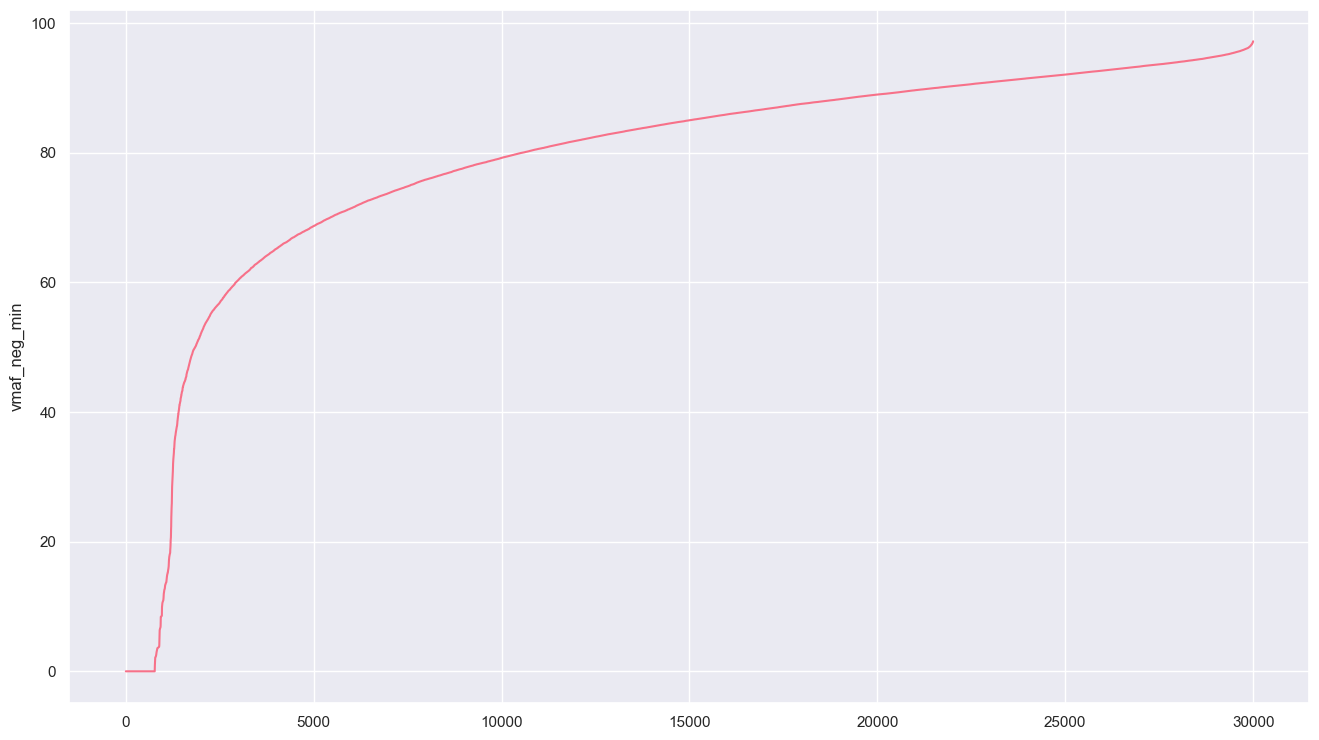

In [68]:
sns.lineplot(aggregated_quality['vmaf_neg_min'].sort_values().reset_index()['vmaf_neg_min'])

In [135]:
big_features.columns

Index(['name_', 'width_min', 'height_min', 'format_first', 'CTI_std_min',
       'CTI_std_mean', 'CTI_std_median', 'CTI_std_max', 'SI_std_min',
       'SI_std_mean', 'SI_std_median', 'SI_std_max', 'TI_std_min',
       'TI_std_mean', 'TI_std_median', 'TI_std_max', 'CTI_mean_min',
       'CTI_mean_mean', 'CTI_mean_median', 'CTI_mean_max', 'SI_mean_min',
       'SI_mean_mean', 'SI_mean_median', 'SI_mean_max', 'TI_mean_min',
       'TI_mean_mean', 'TI_mean_median', 'TI_mean_max',
       'GLCM_correlation_mean_min', 'GLCM_correlation_mean_mean',
       'GLCM_correlation_mean_median', 'GLCM_correlation_mean_max',
       'GLCM_contrast_mean_min', 'GLCM_contrast_mean_mean',
       'GLCM_contrast_mean_median', 'GLCM_contrast_mean_max',
       'GLCM_energy_mean_min', 'GLCM_energy_mean_mean',
       'GLCM_energy_mean_median', 'GLCM_energy_mean_max',
       'GLCM_homogeneity_mean_min', 'GLCM_homogeneity_mean_mean',
       'GLCM_homogeneity_mean_median', 'GLCM_homogeneity_mean_max',
       'GLCM_co

/Users/tiunovnn/git/video-compression-model/.venv/lib/python3.12/site-packages/numpy/lib/_scimath_impl.py:383: RuntimeWarning: divide by zero encountered in divide
  return nx.log(x)/nx.log(n)


Text(-100, 10, 'Оптимальность')

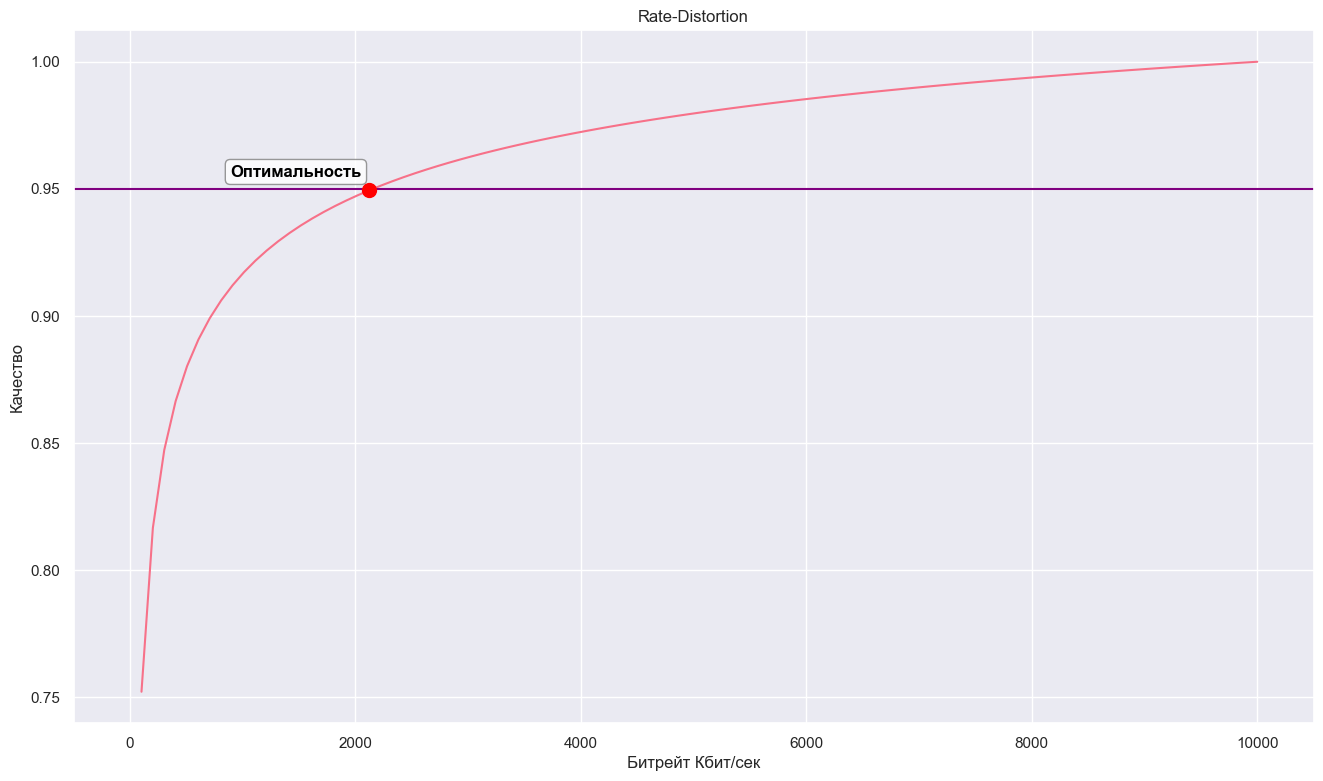

In [ ]:
import numpy as np
head = 10000
data = (np.emath.logn(np.linspace(1, head, 100), 1/head) + 2) / 4 + 0.75
x = np.linspace(1, head, 100)
plot = sns.lineplot(y=data, x=x)
plot.set_title('Rate-Distortion')
plot.set_xlabel('Битрейт Кбит/сек')
plot.set_ylabel('Качество')
plot.axline((0, 0.95), slope=0, color='purple')

intersection_idx = np.argmin(np.abs(data - 0.95))
intersection_x = x[intersection_idx]
intersection_y = data[intersection_idx]

# Добавляем точку на месте пересечения
plot.scatter(intersection_x, intersection_y, color='red', s=100, zorder=5)

# Добавляем текст "Оптимальность" к точке
plot.annotate("Оптимальность",
             (intersection_x, intersection_y),
             xytext=(-100, 10),  # смещение текста относительно точки
             textcoords='offset points',
             fontsize=12,
             color='black',
             weight='bold',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


In [161]:
np.log?

Signature:       np.log(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'log'>
File:            ~/git/video-compression-model/.venv/lib/python3.12/site-packages/numpy/__init__.py
Docstring:      
log(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])

Natural logarithm, element-wise.

The natural logarithm `log` is the inverse of the exponential function,
so that `log(exp(x)) = x`. The natural logarithm is logarithm in base
`e`.

Parameters
----------
x : array_like
    Input value.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    

In [ ]:
vlog_df = aggregated_quality[aggregated_quality.source_name == 'Animation_1080P-0c4f']

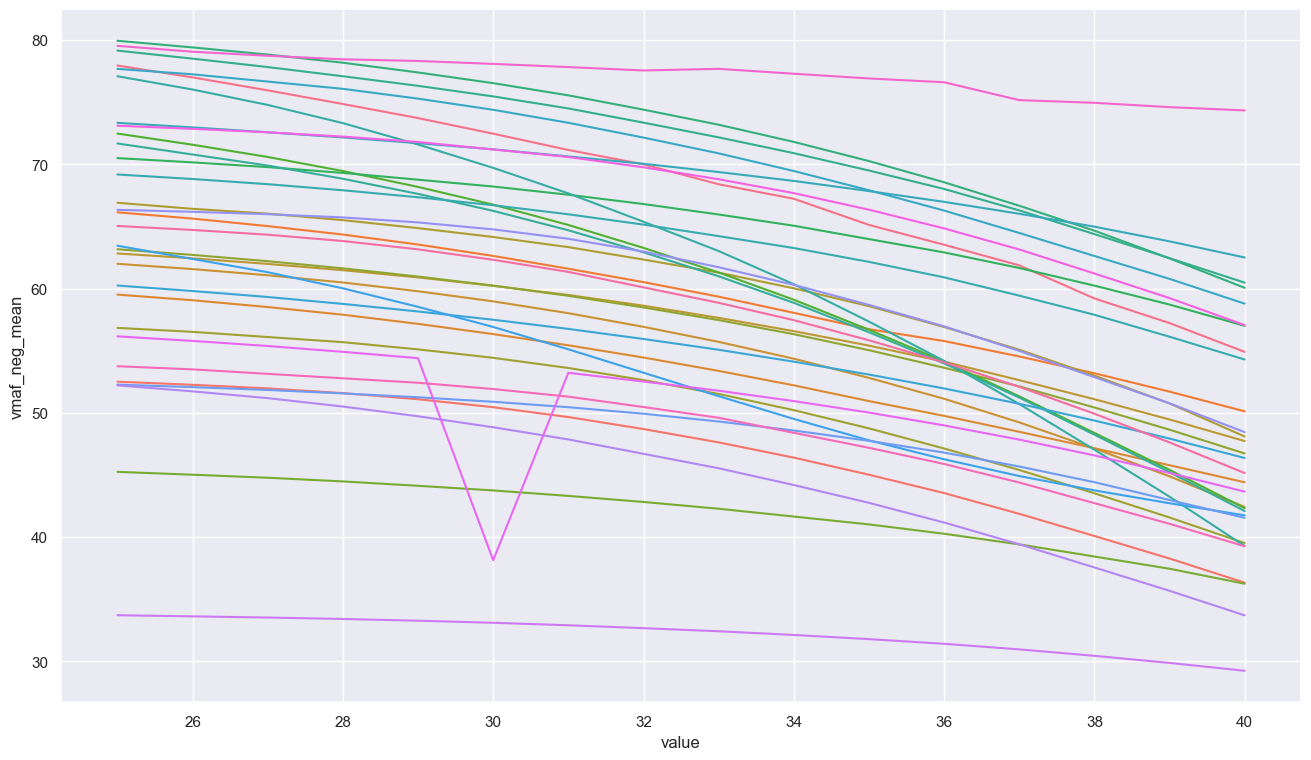

In [78]:
plt.figure(figsize=(16,9))
plot = sns.lineplot(aggregated_quality[(aggregated_quality['parameter'] == 'qp') & aggregated_quality['source_name'].isin(wrong_sources)], x='value', y='vmaf_neg_mean', hue='source_name')
plot.ticklabel_format(axis='y', style='plain')
plt.legend([],[], frameon=False)

In [77]:
wrong_sources = aggregated_quality[(aggregated_quality['parameter'] == 'qp') & (aggregated_quality['value'] < 26) & (aggregated_quality['vmaf_neg_mean'] < 80)]['source_name'].unique()

In [81]:
aggregated_quality[(aggregated_quality['parameter'] == 'qp') & (aggregated_quality['value'] < 26) & (aggregated_quality['vmaf_neg_mean'] > 90)]

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
9,Animation_1080P-05f8,qp,25,90.485480,95.702586,95.060928,100.000000
31,Animation_1080P-0c4f,qp,25,92.493077,94.312309,93.802343,100.000000
79,Animation_1080P-209f,qp,25,94.089540,95.402239,95.355632,99.313822
109,Animation_1080P-21dd,qp,25,42.574393,99.428051,100.000000,100.000000
139,Animation_1080P-2fbe,qp,25,87.048437,95.556841,96.617345,100.000000
...,...,...,...,...,...,...,...
29864,Vlog_720P-3e9c,qp,25,91.893792,93.485628,93.286395,94.998867
29894,Vlog_720P-4e3d,qp,25,92.568287,97.181160,100.000000,100.000000
29924,Vlog_720P-5364,qp,25,77.876821,92.039286,91.675607,100.000000
29954,Vlog_720P-60f8,qp,25,93.099065,99.489412,100.000000,100.000000


In [83]:
import shutil

executable_name = 'ffprobe'
possible_bin_dirs = [
    f'./{executable_name}',
    executable_name,
]

for bin_ in possible_bin_dirs:
    if resolved_binary := shutil.which(bin_):
        ffprobe_bin = resolved_binary
        break
ffprobe_bin

'/opt/homebrew/bin/ffprobe'

In [96]:
import subprocess
import json

def analyze_file(url):
    input_params = [
        '-seekable', '1',
        '-reconnect_delay_max', '300',
        '-multiple_requests', '1',
        '-reconnect_on_http_error', '429,5xx',
        '-reconnect_on_network_error', '1',
        '-i', url,
    ]
    analyze_params = [
        '-show_streams',
        '-show_format',
        '-print_format', 'json'
    ]
    global_params = [
        '-hide_banner',
        '-loglevel', 'error',
    ]

    # Run the command
    try:
        result = subprocess.run(
            [
                ffprobe_bin,
                *input_params,
                *analyze_params,
                *global_params
            ], check=True, capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        logging.error(f"Error analyze video: {e.stderr}")
        raise RuntimeError(str(e.stderr)) from e
    data = json.loads(result.stdout)
    return {
        'duration': data['streams'][0]['duration'],
        'bit_rate': data['streams'][0]['bit_rate'],
        'size': data['format']['size']
    }

In [92]:
analyze_file('/Users/tiunovnn/Downloads/Gaming_1080P-13e3_qp_25.mkv')

{'duration': '20.003316', 'bit_rate': '21972714', 'size': '54959976'}

,source_name,parameter,value,vmaf_neg_min,vmaf_neg_mean,vmaf_neg_median,vmaf_neg_max
0,Animation_1080P-05f8,crf,17,94.140357,97.627268,97.245841,100.0
1,Animation_1080P-05f8,crf,18,93.809997,97.482780,96.818206,100.0
2,Animation_1080P-05f8,crf,19,93.572339,97.321157,96.266597,100.0
3,Animation_1080P-05f8,crf,20,93.281218,97.130756,95.895994,100.0
4,Animation_1080P-05f8,crf,21,92.991453,96.902823,95.747015,100.0
...,...,...,...,...,...,...,...
29995,Vlog_720P-6d56,qp,36,61.691553,81.794359,79.423987,100.0
29996,Vlog_720P-6d56,qp,37,56.549579,78.906290,76.757324,100.0
29997,Vlog_720P-6d56,qp,38,52.161389,75.671001,73.516446,100.0
29998,Vlog_720P-6d56,qp,39,46.798782,72.508412,70.184381,100.0


In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
encoded_bucket = 'tnn-video-encoded'

full_feature_df = []
paths = list(iter_over_bucket(s3_client, encoded_bucket))

def analyze_encoded_video(path: str):
    presigned_url = s3_client.generate_presigned_url(
        'get_object',
        Params={'Bucket': encoded_bucket, 'Key': path},
        ExpiresIn=3600 * 24,
    )
    result = analyze_file(presigned_url)
    result.update(parse_name({'path': path}))
    return result

items = []
with ThreadPoolExecutor(max_workers=6) as pool:
    for result in tqdm(pool.map(analyze_encoded_video, paths), total=len(paths)):
        items.append(result)

analyzed_encoded_df = pd.DataFrame(items)
analyzed_encoded_df

  7%|▋         | 2152/30053 [04:55<55:27,  8.38it/s]  